#**COVID Detection with X-Rays**

importing the libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import os
import cv2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/covid X ray.zip')
zip_ref.extractall('/tmp')
zip_ref.close()

In [5]:
os.listdir('/tmp/COVID-19_Radiography_Dataset')

['Normal', 'COVID']

In [6]:
len(os.listdir('/tmp/COVID-19_Radiography_Dataset/COVID/images/'))

3616

In [7]:
len(os.listdir('/tmp/COVID-19_Radiography_Dataset/Normal/images'))

10192

***We can clearly see that our dataset is inbalanced by the looking at the number of 2 different classes.***

In [8]:
root_dir = '/tmp/COVID-19_Radiography_Dataset'
number_of_img = {}

for dir in os.listdir(root_dir):
  number_of_img[dir] = len(os.listdir(os.path.join(root_dir,dir+"/images/")))

In [9]:
number_of_img

{'COVID': 3616, 'Normal': 10192}

We shall split the dataset into:-
* 70% training data
* 15% testing data
* 15% validation data

In [10]:
import math
import shutil

creating the directories - train, test, val

In [11]:
def datafolder(path, split):
  if not os.path.exists("./"+path):
    os.mkdir("./"+path)     # root ---> train(path)

    for dir in os.listdir(root_dir):
      os.makedirs("./"+path+"/"+dir)     # root --> train ---> COVID/normal
      for img in np.random.choice(a=os.listdir(os.path.join(root_dir,dir + "/images/")),
                                  size=(math.floor(split*number_of_img[dir])),
                                  replace=False):
        O = os.path.join(root_dir, dir+ "/images/", img)  # origin
        D = os.path.join("./"+path,dir)       # destination root --> train ---> covid ---> imgfile
        shutil.copy(O,D)
        os.remove(O)
  else:
    print("Path already exists")

In [12]:
datafolder('train', 0.7)

In [13]:
train_n_img = {}
for dir in os.listdir("./train/"):
  train_n_img[dir] = len(os.listdir(os.path.join("./train/",dir)))

In [14]:
train_n_img

{'COVID': 2531, 'Normal': 7134}

In [15]:
datafolder('test',0.15)

In [16]:
datafolder('val',0.15)

***Data visualization***

In [17]:
os.listdir('train/Normal/')[:3]

['Normal-7312.png', 'Normal-6391.png', 'Normal-4197.png']

In [18]:
os.listdir('train/COVID/')[:3]

['COVID-3206.png', 'COVID-2079.png', 'COVID-403.png']

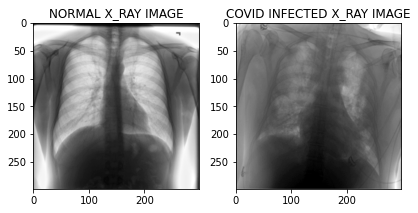

In [20]:
fig, axes = plt.subplots(1,2)
axes[0].imshow(imread('train'+'/Normal/Normal-6391.png'), cmap='binary')
axes[0].title.set_text("NORMAL X_RAY IMAGE")

axes[1].imshow(imread('train'+'/COVID/COVID-2079.png'), cmap='binary')
axes[1].title.set_text("COVID INFECTED X_RAY IMAGE")

plt.tight_layout()
plt.autoscale(enable=True, axis='both')

In [22]:
imread('train'+'/COVID/COVID-2079.png').shape

(299, 299)

## Building Deep Learning model

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout

In [24]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(150,150,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

In [25]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

## Data pre-processing

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [28]:
def preprocessing(path):
  image_data = ImageDataGenerator(width_shift_range=0.1,
                                  shear_range=0.2,
                                  horizontal_flip=True,
                                  zoom_range=0.1)
  image = image_data.flow_from_directory(directory=path, target_size=(150,150),
                                         color_mode='grayscale',
                                         batch_size=32,
                                         class_mode='binary')
  return image

In [29]:
train_data = preprocessing('/content/train')

Found 9665 images belonging to 2 classes.


In [30]:
def preprocessing2(path):
  image_data = ImageDataGenerator()
  image = image_data.flow_from_directory(directory=path, target_size=(150,150),
                                         color_mode='grayscale',
                                         batch_size=32,
                                         class_mode='binary',
                                         shuffle=False)
  return image

In [31]:
test_data = preprocessing2('/content/test')
val_data = preprocessing2('/content/val')

Found 2070 images belonging to 2 classes.
Found 2070 images belonging to 2 classes.


In [32]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss', patience=2)
mc = ModelCheckpoint(monitor='val_loss', filepath='./bestmodel.h5', 
                     save_best_only=True,
                     mode='auto')

cb = [early_stop, mc]

In [33]:
from gc import callbacks
model.fit(train_data, epochs=50, validation_data=val_data, callbacks=cb)

Epoch 1/50
303/303 [==============================] - 61s 166ms/step - loss: 2.4867 - accuracy: 0.7296 - val_loss: 0.4612 - val_accuracy: 0.7676
Epoch 2/50
303/303 [==============================] - 48s 158ms/step - loss: 0.5235 - accuracy: 0.7638 - val_loss: 0.5112 - val_accuracy: 0.7512
Epoch 3/50
303/303 [==============================] - 49s 161ms/step - loss: 0.4814 - accuracy: 0.7694 - val_loss: 0.3998 - val_accuracy: 0.8034
Epoch 4/50
303/303 [==============================] - 49s 163ms/step - loss: 0.4300 - accuracy: 0.7928 - val_loss: 0.3981 - val_accuracy: 0.8082
Epoch 5/50
303/303 [==============================] - 48s 158ms/step - loss: 0.3948 - accuracy: 0.8125 - val_loss: 0.4004 - val_accuracy: 0.8203
Epoch 6/50
303/303 [==============================] - 48s 158ms/step - loss: 0.3982 - accuracy: 0.8137 - val_loss: 0.3726 - val_accuracy: 0.8198
Epoch 7/50
303/303 [==============================] - 48s 158ms/step - loss: 0.3751 - accuracy: 0.8223 - val_loss: 0.3198 - val_ac

In [34]:
df = pd.DataFrame(model.history.history)
df

,loss,accuracy,val_loss,val_accuracy
0,2.486670,0.729643,0.461153,0.767633
1,0.523518,0.763787,0.511151,0.751208
2,0.481365,0.769374,0.399792,0.803382
3,0.429956,0.792757,0.398068,0.808213
4,0.394830,0.812519,0.400389,0.820290
5,0.398168,0.813658,0.372630,0.819807
6,0.375104,0.822349,0.319771,0.855072
7,0.354484,0.834351,0.304894,0.869565
8,0.344887,0.839834,0.276551,0.880193
9,0.318383,0.851009,0.277863,0.879227


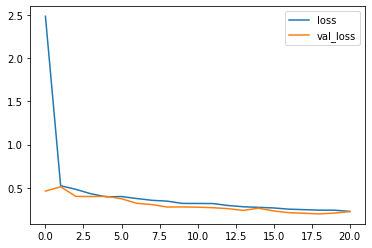

In [35]:
df[['loss','val_loss']].plot()

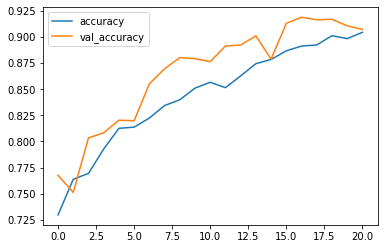

In [36]:
df[['accuracy','val_accuracy']].plot()

In [37]:
from tensorflow.keras.models import load_model
best_model = load_model('/content/bestmodel.h5')

Model Evaluation

In [38]:
print("The accuracy of the model: ", best_model.evaluate(test_data)[1])

65/65 [==============================] - 5s 76ms/step - loss: 0.2027 - accuracy: 0.9256
The accuracy of the model:  0.9256038665771484


Predictions

In [40]:
from tensorflow.keras.preprocessing import image
img = image.load_img('/content/test/COVID/COVID-1001.png',
                       target_size=(150,150),
                      color_mode='grayscale')
img_arr = image.img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)

Text(0.5, 1.0, 'To be predicted')

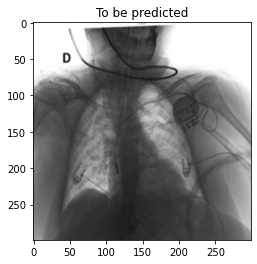

In [42]:
plt.imshow(imread('/content/test/COVID/COVID-1001.png'), cmap='binary')
plt.title("To be predicted")

In [43]:
pred = best_model.predict(img_arr)
pred_classes = (pred > 0.5).astype('int32')
pred_classes

array([[0]], dtype=int32)

In [44]:
test_data.class_indices

{'COVID': 0, 'Normal': 1}

In [45]:
if pred_classes == 0:
  print("COVID infected - tested positive!!!")
elif pred_classes == 1:
  print("NORMAL - tested negative")
else:
  print("Not known!!!")

COVID infected - tested positive!!!


In [46]:
pred_total = best_model.predict(test_data)
pred_classes_total = (pred_total > 0.5).astype("int32")

In [47]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(test_data.classes, pred_classes_total))
print(classification_report(test_data.classes, pred_classes_total))

[[ 404  138]
 [  16 1512]]
              precision    recall  f1-score   support

           0       0.96      0.75      0.84       542
           1       0.92      0.99      0.95      1528

    accuracy                           0.93      2070
   macro avg       0.94      0.87      0.90      2070
weighted avg       0.93      0.93      0.92      2070



***We achieved 93% accuracy using the custom CNN model***

## Transfer Learning Techniques

In [58]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input

In [74]:
def preprocessing(path):
  image_data = ImageDataGenerator(
                                   width_shift_range=0.1,
                                   zoom_range=0.1,
                                   preprocessing_function=preprocess_input,
                                   shear_range=0.2,
                                   horizontal_flip=True)
  image = image_data.flow_from_directory(directory=path, target_size=(150,150),
                                         color_mode='grayscale',
                                         batch_size=16, class_mode='binary')
  return image

In [75]:
def preprocessing2(path):
  image_data = ImageDataGenerator(
                                   preprocessing_function=preprocess_input)
  image = image_data.flow_from_directory(directory=path, target_size=(150,150),
                                         color_mode='grayscale', shuffle=False,
                                         batch_size=16, class_mode='binary')
  return image

In [76]:
train__data = preprocessing('/content/train')

Found 9665 images belonging to 2 classes.


In [77]:
test__data = preprocessing2('/content/test')
val__data = preprocessing2('/content/val')

Found 2070 images belonging to 2 classes.
Found 2070 images belonging to 2 classes.


In [63]:
base_model = MobileNet(input_shape=(150,150,3),
                   include_top = False)

17235968/17225924 [==============================] - 1s 0us/step


In [64]:
# to make sure we won't re-train the model again
for layer in base_model.layers:
  layer.trainable = False

In [65]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 75, 75, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 75, 75, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 75, 75, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 75, 75, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 75, 75, 32)       128       
 ation)                                         

In [66]:
# club the pre-trained model with our custom model
X =Flatten()(base_model.output)  # last layer in base_model
X = Dense(units=1, activation='sigmoid')(X)

In [67]:
tf_model = Model(base_model.input, X)

In [68]:
tf_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 75, 75, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 75, 75, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 75, 75, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 75, 75, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 75, 75, 32)       128       
 ation)                                                      

In [69]:
tf_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [70]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
mc = ModelCheckpoint(monitor='val_loss', filepath='./bestmodel2.h5',save_best_only=True, mode='auto')

cb = [early_stop,mc]

In [78]:
result_tf = tf_model.fit(train__data, 
                         epochs=30, 
                         validation_data=val__data, 
                         callbacks=cb)

Epoch 1/30


InvalidArgumentError: ignored